# Predicción del género musical de canciones
### Autor: Guillermo Errázuriz
### Fecha: 2020-07-13
------

## Preliminares

El objetivo de este trabajo es determinar el género musical de canciones a partir de sus letras. Para lograr esto, se implementará un modelo de clasificación múltiple con Naive Bayes.

## Importación de los datos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
paths = glob.glob(os.getcwd() + "\\dump\\*")

In [3]:
df_dict = {}
for i, path in enumerate(paths):
    df_dict[i] = pd.read_csv(path, index_col = 0)

In [4]:
df = pd.concat(df_dict, ignore_index = True)

In [5]:
df.rename(columns = {"0": "artist", "1": "genre", "2": "title", "3": "lyrics"}, inplace = True)

In [6]:
df

,artist,genre,title,lyrics
0,Anthrax,metal,Deathrider,"Riding hard, high in the saddle \n Winged stee..."
1,Anthrax,metal,Metal Thrashing Mad,Racing down the road \n In a street machine of...
2,Anthrax,metal,I'm Eighteen,Lines form on my face and hands \n Lines form ...
3,Anthrax,metal,Panic,Move it to the front \n Reaching for the light...
4,Anthrax,metal,Subjugator,Out in the streets \n We're fighting tonight \...
...,...,...,...,...
9484,Weezer,rock,"Thief, You've Taken All That Was Me","Thief, of silent dreams \n Of golden scenes \n..."
9485,Weezer,rock,We Are All In Love,When your out with your friends \n In your new...
9486,Weezer,rock,We Go Together,We go together \n And that's to stay \n And in...
9487,Weezer,rock,What Is This I Find?,[Jonas]: \n What is this I find? \n [Wuan]: \n...


## Descripción de los datos

Text(0.5, 0, 'Cantidad de canciones')

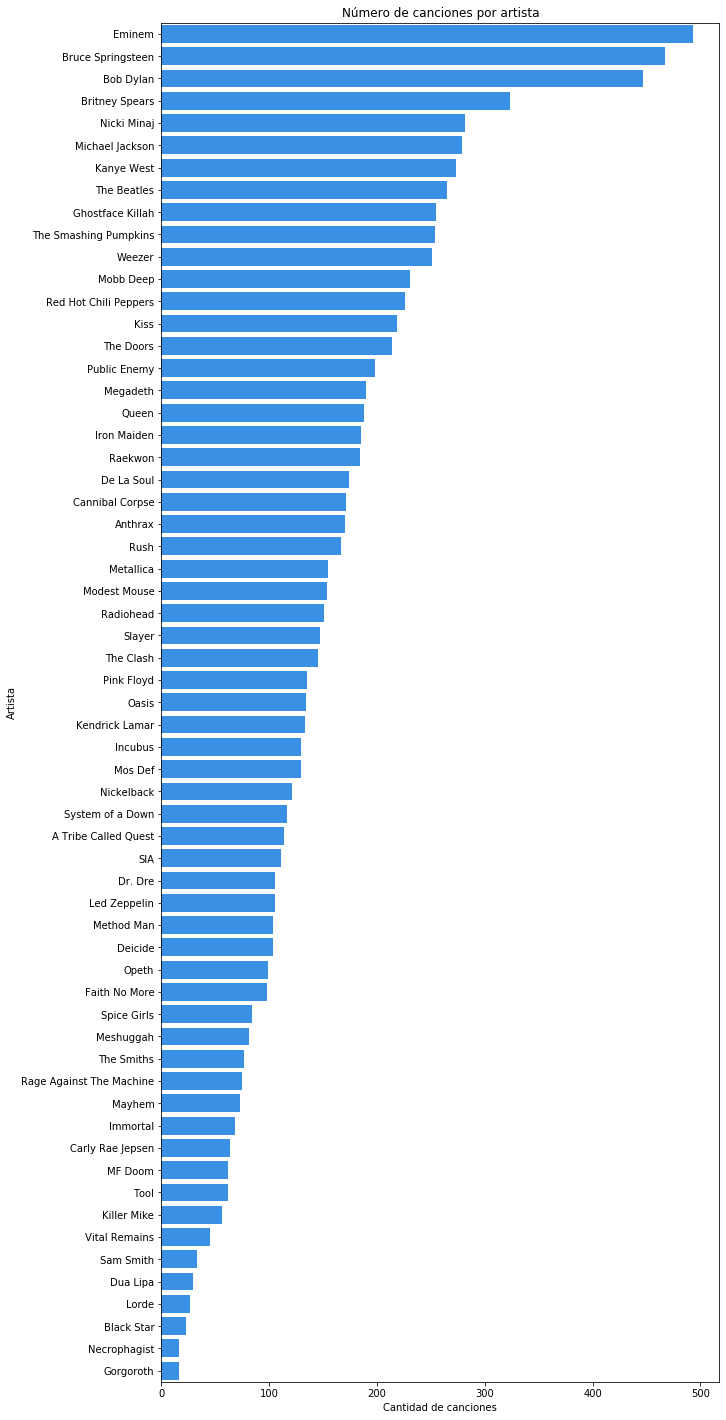

In [14]:
order1 = df["artist"].value_counts().keys()
plt.figure(figsize = (10,25))
ax1 = sns.countplot(y = df["artist"], order = order1, color = "dodgerblue")
ax1.set_title("Número de canciones por artista")
ax1.set_ylabel("Artista")
ax1.set_xlabel("Cantidad de canciones")

Text(0.5, 0, 'Género')

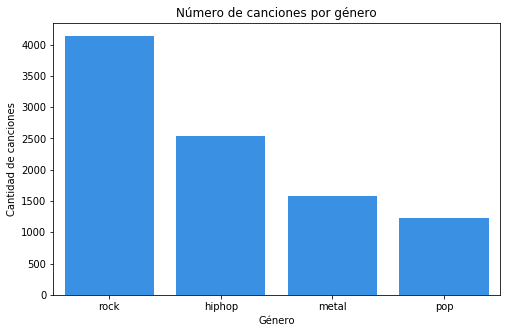

In [15]:
order2 = df["genre"].value_counts().keys()
plt.figure(figsize = (8,5))
ax2 = sns.countplot(x = df["genre"], order = order2, color = "dodgerblue")
ax2.set_title("Número de canciones por género")
ax2.set_ylabel("Cantidad de canciones")
ax2.set_xlabel("Género")

In [16]:
df[df.artist == "Eminem"]["genre"].value_counts()

hiphop    493
Name: genre, dtype: int64

Sin duda hay un desbalance de canciones entre los artistas, dado que Eminem, Bruce Springsteen y Bob Dylan tienen casi 500 canciones cada uno, mientras que cerca del 40% de los artistas no superan ni las 100. Y por ejemplo, en el caso del hip hop, Eminem es responsable de alrededor de 20% de las canciones, por lo que existe el riesgo de que el modelo asocie a ese género palabras que son particulares de ese artista.

## Recodificación

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

CountVectorizer crea una matriz dispersa como representación de la frecuencia de palabras en una colección de textos.

**Top 100 palabras**

In [18]:
count_vectorizer = CountVectorizer(stop_words = 'english', max_features = 100)
count_vectorizer_fit = count_vectorizer.fit_transform(df["lyrics"])
words = count_vectorizer.get_feature_names()
words_freq = count_vectorizer_fit.toarray().sum(axis=0)
df_freq = pd.DataFrame({"word": words, "frequency": words_freq})
df_freq.sort_values(by = ["frequency"], inplace = True, ascending = False)
df_freq.reset_index(drop = True, inplace = True)
df_freq

,word,frequency
0,like,19629
1,don,17398
2,know,14962
3,got,14171
4,just,13978
...,...,...
95,death,1897
96,left,1895
97,thing,1882
98,end,1829


**Top 100 palabras por género**

In [23]:
def top_100_words(dataframe, genre_to_filter):
    count_vectorizer_tmp = CountVectorizer(stop_words = 'english', max_features = 100)
    df_tmp = dataframe[dataframe.genre == genre_to_filter]
    count_vectorizer_fit_tmp = count_vectorizer_tmp.fit_transform(df_tmp["lyrics"])
    words_tmp = count_vectorizer_tmp.get_feature_names()
    words_freq_tmp = count_vectorizer_fit_tmp.toarray().sum(axis=0)
    df_freq_tmp = pd.DataFrame({"word": words_tmp, "frequency": words_freq_tmp})
    df_freq_tmp.sort_values(by = ["frequency"], inplace = True, ascending = False)
    df_freq_tmp.reset_index(drop = True, inplace = True)
    return df_freq_tmp[0:100]

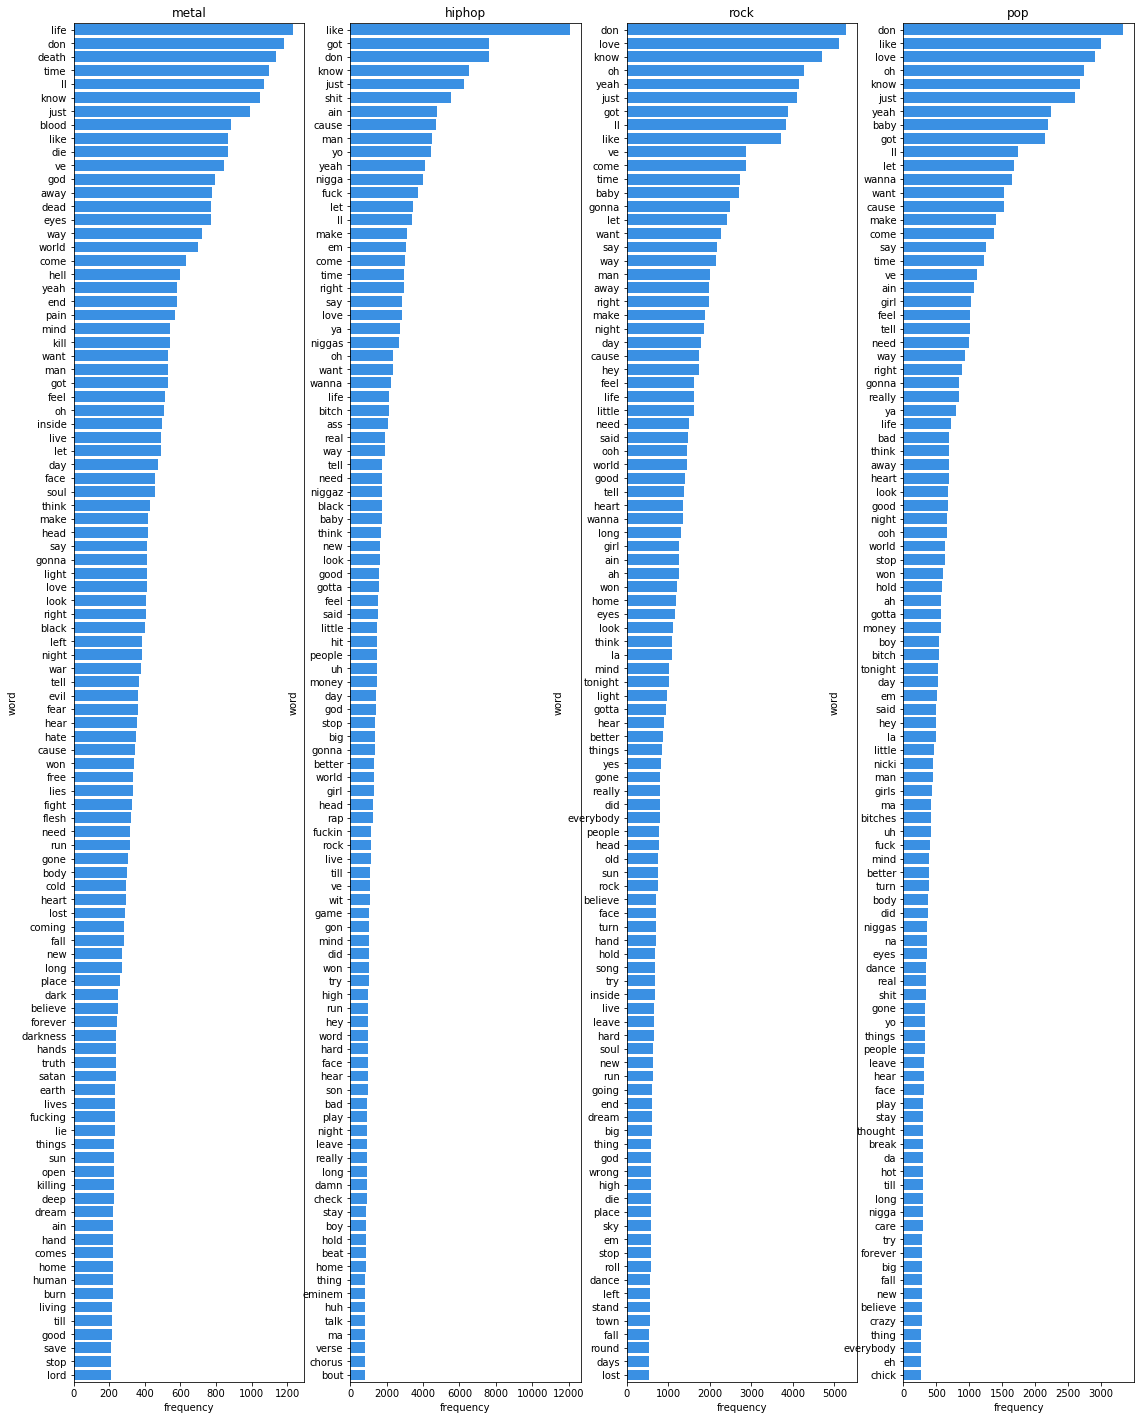

In [24]:
plt.figure(figsize = (19,25))
for i, genre in enumerate(df["genre"].unique()):
    plt.subplot(1,4,i+1)
    top100words = top_100_words(df, genre) # Función aplicada a cada uno de los cuatro géneros
    ax = sns.barplot(y = top100words["word"], x = top100words["frequency"], color = "dodgerblue")
    ax.set_title(genre)

En principio se podría esperar que las frecuencias más altas estuvieran en los géneros más frecuentes, pero se observa que estas son más altas en el hip hop que en el rock. Esto tiene sentido dado que el género se caracteriza por tener letras extensas. Por el lado contrario, el género con las frecuencias más bajas es el metal, lo cual también tiene sentido dado que muchas canciones son en gran parte instrumentales.

Adicionalmente, las frecuencias tienden a bajar de manera gradual a medida que descendemos en el ranking, con la excepción de la palabra "like" en el hip hop, que está por una gran distancia en primer lugar con cerca de 12.000 apariciones. Si vemos los primeros lugares, se observa que hay palabras particulares a cada género, como "life", "time", "death", "god", "blood" y "die" en el metal y "ain" (ain't), "shit", "cause", "man" y "nigga" en el hip hop, mientras que entre el rock y el pop hay muchas palabras en común, como "love" y "baby". Finalmente, también hay palabras como "don" (don't) y "know" que aparecen en todos los géneros.

## Entrenamiento del modelo

In [57]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [58]:
X_train, X_test, y_train, y_test = train_test_split(df["lyrics"], df["genre"], test_size = 0.4, random_state = 1542)

In [59]:
pipeline_model = Pipeline([('countv', CountVectorizer(stop_words = 'english')),
                        ('model', MultinomialNB())])

In [60]:
pipeline_model.fit(X_train, y_train)
y_hat = pipeline_model.predict(X_test)

**Predicción letras de ejemplo**

In [61]:
example_lyrics = ['I got a place in the underworld', # Brody Dalle - Underworld
    'As veils of ignorance, hatred retains Storm of arrows through karma Seeking light through samsara', # Gorguts - Forgotten Arrows
    "Bye bye Don't want to be a fool for you Just another player in your game for two You may hate me but it ain't no lie", # N'SYNC - Bye Bye Bye
    'Move bitch, get out the way Get out the way bitch, get out the way Move bitch, get out the way Get out the way bitch, get out the way', # Ludacris - Move B*tch
    'Sexual violence doesn’t start and end with rape It starts in our books and behind our school gates', # IDLES - Mother
    "Take it from the girl you claimed to love You gonna get some bad karma I'm the one who had to learn to \ build a heart made of armor From the girl who made you soup and tied your shoes when you were hurting\ You are not deserving, you are not deserving", #Banks - Drowning
    ]

In [62]:
example_prediction = pipeline_model.predict(example_lyrics)

In [63]:
print(example_prediction)

['rock' 'metal' 'rock' 'pop' 'metal' 'rock']


**Métricas del modelo a partir del conjunto de test**

In [64]:
genres = sorted(df["genre"].unique())
conf_matrix = confusion_matrix(y_test, y_hat, labels = genres)

El eje Y corresponde al género real, y el eje X al predicho por el modelo.

Text(0.5, 1, 'Matriz de confusión')

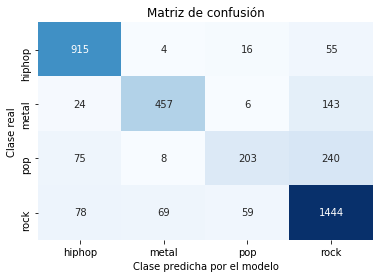

In [67]:
sns.heatmap(pd.DataFrame(conf_matrix, index = genres, columns = genres),
            xticklabels = genres, yticklabels = genres, 
            annot = True, fmt = "1", cbar = False, cmap = 'Blues');
plt.xlabel("Clase predicha por el modelo")
plt.ylabel("Clase real")
plt.title("Matriz de confusión")

In [68]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

      hiphop       0.84      0.92      0.88       990
       metal       0.85      0.73      0.78       630
         pop       0.71      0.39      0.50       526
        rock       0.77      0.88      0.82      1650

    accuracy                           0.80      3796
   macro avg       0.79      0.73      0.75      3796
weighted avg       0.79      0.80      0.78      3796



## Mejora del modelo

Podemos ver que el modelo anterior tiene un desbalance de clases, lo cual afecta particularmente al recall de "pop". Este pareciera confundirse con "rock", lo cual coincide con lo que observamos en la exploración de los datos.

Vamos a intentar modificar la muestra para aumentar la representatividad de las clases minoritarias.

In [69]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as Pipeline2

In [70]:
pipeline_model2 = Pipeline2([('countv', CountVectorizer(stop_words = 'english')),
                            ('smt', RandomOverSampler(random_state = 6261)), 
                            ('model', MultinomialNB())])

In [71]:
pipeline_model2.fit(X_train, y_train)
y_hat = pipeline_model2.predict(X_test)

**Muestra en el primer modelo**

In [72]:
pd.DataFrame([pipeline_model.named_steps["model"].class_count_], columns = genres, index = ["frecuencia"])

,hiphop,metal,pop,rock
frecuencia,1545.0,952.0,706.0,2490.0


**Muestra en el modelo mejorado**

In [73]:
pd.DataFrame([pipeline_model2.named_steps["model"].class_count_], columns = genres, index = ["frecuencia"])

,hiphop,metal,pop,rock
frecuencia,2490.0,2490.0,2490.0,2490.0


In [74]:
conf_matrix = confusion_matrix(y_test, y_hat, labels = genres)

Text(0.5, 1, 'Matriz de confusión')

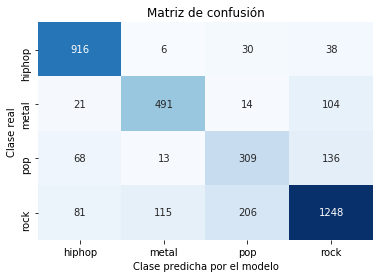

In [75]:
sns.heatmap(pd.DataFrame(conf_matrix, index = genres, columns = genres),
            xticklabels = genres, yticklabels = genres, 
            annot = True, fmt = "1", cbar = False, cmap = 'Blues');
plt.xlabel("Clase predicha por el modelo")
plt.ylabel("Clase real")
plt.title("Matriz de confusión")

In [76]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

      hiphop       0.84      0.93      0.88       990
       metal       0.79      0.78      0.78       630
         pop       0.55      0.59      0.57       526
        rock       0.82      0.76      0.79      1650

    accuracy                           0.78      3796
   macro avg       0.75      0.76      0.76      3796
weighted avg       0.78      0.78      0.78      3796



*Se realizaron pruebas con RandomOverSampler, SMOTE y ADASYN, e incluso con RandomUnderSampler. Nos quedamos con el primero porque fue el que dio mejores resultados.

Si nos concentramos en los F1, podemos ver que el modelo mejoró para pop, pero empeoró para rock. Específicamente, el modelo está apostando más por metal y pop, lo cual se refleja en un mayor recall, pero menor precision, y lo opuesto para rock.

Para nuestro conjunto de test no parece ser positivo dado que hay una baja en accuracy y no hay diferencia en el F1 ponderado, pero esto se debe a la alta frecuencia de rock. De hecho, el promedio simple de F1 es ligeramente mayor.

En conclusión, si queremos un modelo más robusto, que se comporte bien ante canciones de cualquier género, dado que creemos que en la práctica las clases estarán más balanceadas, es mejor el segundo modelo. Ahora bien, si nuestro dataset es representativo de la realidad, y la mayoría de las canciones que se van a intentar clasificar son de rock, estas se identifican correctamente con mayor frecuencia con el primer modelo.